## Data Gathering

For this project, there're three data sources that we need to fetch from. Firstly, we need to simply read and process the already-defined `twitter-archive-enhanced.csv` set from the project directory, which contains the bulk of the information of the dataset. Secondly, we'll utilize the `request` library to fetch `image-predictions.tsv` from Udaciy's remote server. Lastly, we'll take advantage of the Twitter API and run mass queries against all the tweets from `twitter-archive-enhanced.csv` to fetch their `retweet_count` and `favorite_count` columns.

In [2]:
#import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import tweepy
import json
import io
import os
%matplotlib inline 

In [3]:
# load the data from WeRateDog's archive file 
archive = pd.read_csv('twitter-archive-enhanced.csv')

In [4]:
# examine twitter archive structure 
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [5]:
# load the data from image predictions file 
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)
c = r.content
image_predictions = pd.read_csv(io.StringIO(c.decode('utf-8')), sep='\t')
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [6]:
# load Twitter auth credentials from .env
%load_ext dotenv
%dotenv

In [7]:
# load retweet & favorite data with Twitter API & Tweepy 
# authenticate with tokens and secrets
auth = tweepy.OAuthHandler(os.getenv("consumer_key"), os.getenv("consumer_secret"))
auth.set_access_token(os.getenv("access_token"), os.getenv("access_token_secret"))
# set wait_on_rate_limit and wait_on_rate_limit_notify to true to allow API to wait for rate limit to replenish
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [9]:
# create the destination file
with open("tweet_json.txt", "w") as dest:
    # loop through each tweet in archive
    for tweet_id in archive['tweet_id']:
        # query with API and convert payload to JSON, then write to the dest file
        try:
            tweet = api.get_status(tweet_id)
            tweet_json = tweet._json
            json.dump(tweet_json, dest)
            dest.write('\n')
        except:
            continue

Rate limit reached. Sleeping for: 475
Rate limit reached. Sleeping for: 735
Rate limit reached. Sleeping for: 734


In [10]:
# initialize an empty list which will be populated with tweet data later
json_list = []
with open("tweet_json.txt", encoding='UTF-8') as f:
    # loop through each line in the file 
    for line in f:
        # load the data to a Python dict
        data_json = json.loads(line.strip())
        # retreat the values then store it in a new dictionary which will be parsed to the list
        id = data_json['id']
        retweet_count = data_json['retweet_count']
        favorite_count = data_json['favorite_count']
        json_list.append({
            'tweet_id': id,
            'retweet_count': retweet_count,
            'favorite_count': favorite_count
        })

In [11]:
# convert the list to a Pandas dataframe 
api_data = pd.DataFrame(json_list, columns=['tweet_id', 'retweet_count', 'favorite_count'])

## Data Assessing

For the assessment step, we'll examine the data by both visual and programmatic inspection. For each of the three data sources we have, we'll first fetch some sample rows and take a look to see if there's any peculiarities. If so, we'll dive deeper with Pandas queries and commands.

In [12]:
print(archive.shape[0])
print(image_predictions.shape[0])
print(api_data.shape[0])

2356
2075
2333


In [13]:
# examine the twitter archive
archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
408,823581115634085888,NaN,NaN,2017-01-23 17:20:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Crawford. He's quite h*ckin good at th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/823581115...,11,10,Crawford,None,None,None,None
2107,670465786746662913,NaN,NaN,2015-11-28 04:54:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Silly dog here. Wearing bunny ears. Nice long ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670465786...,7,10,None,None,None,None,None
534,807106840509214720,NaN,NaN,2016-12-09 06:17:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Stephan. He just wants to help. 13/10 ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/807106840...,13,10,Stephan,None,None,None,None
23,887473957103951883,NaN,NaN,2017-07-19 00:47:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Canela. She attempted some fancy porch...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
1255,710609963652087808,NaN,NaN,2016-03-17 23:33:12 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",I've watched this a million times and you prob...,NaN,NaN,NaN,https://vine.co/v/idaTpwH5TgU,12,10,None,None,None,None,None


In [14]:
# To get started, let's see if we have any dups in tweets. 
duplicateTweet = archive[archive.duplicated(['tweet_id'])]
print(duplicateTweet)

Empty DataFrame
Columns: [tweet_id, in_reply_to_status_id, in_reply_to_user_id, timestamp, source, text, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls, rating_numerator, rating_denominator, name, doggo, floofer, pupper, puppo]
Index: []


In [15]:
# Theoretically, the denominator should be 10 for all rows. Let' see if that's actually the case
archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [16]:
# Is the timestamp column's data type literally timestamp?
type(archive.loc[2, 'timestamp'])

str

In [17]:
# Looks like there is a lot of rows with null names. Let's examine that
archive.name.value_counts()

None              745
a                  55
Charlie            12
Cooper             11
Oliver             11
Lucy               11
Penny              10
Lola               10
Tucker             10
Bo                  9
Winston             9
Sadie               8
the                 8
Toby                7
Daisy               7
Buddy               7
Bailey              7
an                  7
Stanley             6
Koda                6
Rusty               6
Scout               6
Oscar               6
Bella               6
Milo                6
Jax                 6
Leo                 6
Jack                6
Dave                6
Alfie               5
                 ... 
Florence            1
Doobert             1
Hamrick             1
Michelangelope      1
Dex                 1
Jaspers             1
Mona                1
Mabel               1
Crouton             1
Carper              1
Jeb                 1
Brian               1
Jimbo               1
Rupert              1
Fynn      

In [18]:
# Per project instruction, we only want to include the original tweets. So maybe remove those rows from dataframe because we don't want retweets 
architeRetweeted = archive[archive['retweeted_status_timestamp'].notnull()]
numarchiteRetweeted = architeRetweeted.shape[0]
print(numarchiteRetweeted)

181


In [19]:
# examine the image prediction data source
image_predictions.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
400,673688752737402881,https://pbs.twimg.com/media/CVlsVs3WIAAja6m.jpg,1,soft-coated_wheaten_terrier,0.340806,True,Sealyham_terrier,0.234898,True,kuvasz,0.203495,True
496,675781562965868544,https://pbs.twimg.com/media/CWDbv2yU4AARfeH.jpg,1,Maltese_dog,0.921968,True,West_Highland_white_terrier,0.017811,True,toy_poodle,0.013555,True
779,689905486972461056,https://pbs.twimg.com/media/CZMJYCRVAAE35Wk.jpg,4,Pomeranian,0.943331,True,Shetland_sheepdog,0.023675,True,chow,0.007165,True
2023,881536004380872706,https://pbs.twimg.com/ext_tw_video_thumb/88153...,1,Samoyed,0.281463,True,Angora,0.272066,False,Persian_cat,0.114854,False
352,672538107540070400,https://pbs.twimg.com/media/CVVV1wJWoAEcOyk.jpg,1,Siamese_cat,0.383937,False,Chihuahua,0.160274,True,giant_panda,0.147745,False
347,672475084225949696,https://pbs.twimg.com/media/CVUchRHXAAE4rtp.jpg,1,terrapin,0.879286,False,cockroach,0.045252,False,box_turtle,0.016404,False
793,690735892932222976,https://pbs.twimg.com/media/CZX8nyeVAAEstKM.jpg,1,golden_retriever,0.883229,True,Labrador_retriever,0.109635,True,kuvasz,0.002795,True
842,695051054296211456,https://pbs.twimg.com/media/CaVRP4GWwAERC0v.jpg,1,Boston_bull,0.761454,True,pug,0.075395,True,Chihuahua,0.041598,True
902,700029284593901568,https://pbs.twimg.com/media/CbcA673XIAAsytQ.jpg,1,West_Highland_white_terrier,0.726571,True,Maltese_dog,0.176828,True,Dandie_Dinmont,0.070134,True


In [20]:
# Examine the img_num column
image_predictions.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [21]:
# See if any of the predictions is more than 100%
image_predictions.query('p1_conf >=1 | p2_conf >=1 | p3_conf >=1')

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
106,667866724293877760,https://pbs.twimg.com/media/CUS9PlUWwAANeAD.jpg,1,jigsaw_puzzle,1.0,False,prayer_rug,1.011300e-08,False,doormat,1.740170e-10,False


In [22]:
# examine the data we fetched from the Twitter API
api_data.sample(10)

,tweet_id,retweet_count,favorite_count
1832,675531475945709568,386,1186
623,793226087023144960,3031,10304
2076,670717338665226240,485,1190
2227,667832474953625600,61,289
1410,697482927769255936,691,2468
1159,719332531645071360,974,3485
298,835264098648616962,1750,7925
1616,684188786104872960,1207,3572
603,796116448414461957,2549,9549
516,807621403335917568,3842,15222


In [23]:
# We have some zero favorites for tweets with a high retweet_count. Let's look into this
api_data['favorite_count'].value_counts()

0        165
1093       3
2598       3
1339       3
1825       3
2909       3
1288       3
2697       3
1648       3
1244       3
3212       3
2875       3
2525       3
1102       3
1322       3
2250       2
2897       2
2371       2
1101       2
3664       2
99         2
3503       2
3210       2
496        2
1184       2
2712       2
1110       2
4207       2
663        2
2273       2
        ... 
10508      1
583        1
533        1
6726       1
29207      1
14872      1
2586       1
541        1
12833      1
10790      1
10792      1
4649       1
2602       1
12843      1
10796      1
14898      1
4659       1
6708       1
90230      1
23096      1
2618       1
4667       1
19004      1
736        1
3233       1
53823      1
25153      1
88642      1
19765      1
16351      1
Name: favorite_count, Length: 1973, dtype: int64

### Quality

- retweet rows should be removed
- Erroneous data types (the data type of `timestamp` should be `datetime`, not `str`
- Redundant `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, or `retweeted_status_timestamp` columns
- There are four columns (`doggo`, `floofer`, `puffer`, `puppo`) that belong to the same category and coule be merged to one column
- The source column contains the entire HTML snippet but not the actual URL
- In the image prediction file, the 1st letter of some of the breed is upper-case while some is lower-cased 
- `tweet_id` #667866724293877760 tweet has probabilities greater than 100%
- Some rows have really high retweet counts but 0 favorite count 
- Multiple values of rating denumerator
- There is a row whose rating denominator is 0 

### Tidiness

- Irrelevant values (ratings and URL) from the text column 
- `retweet_count` and `favorite_count` should be in the `archive` table, so does the columns in `image_predictions.tsv`  

## Data Cleaning

In [24]:
# First of all, make a copy of the files just in case
archive_clean = archive.copy()
image_predictions_clean = image_predictions.copy()
api_data_clean = api_data.copy()

### Tidiness

#### Multiple irrelevant values (ratings and URL) from the `text` column

##### Define
Extract the extra values from the text and only leave the text itself to avoid multiple variables stored in same column

##### Code

In [25]:
# Use regex to extract the text part before the rating
archive_clean.text = archive_clean.text.str.extract('([^\d]*)')
# Remove the extra trailing space
archive_clean.text = archive_clean.text.str.strip()

##### Test 

In [26]:
# Grab a couple of the rows and examine
print(archive_clean.at[4, 'text'])
print(archive_clean.at[18, 'text'])
print(archive_clean.at[89, 'text'])

This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such.
This is Ralphus. He's powering up. Attempting maximum borkdrive.
Guys please stop sending pictures without any dogs in th- oh never mind hello excuse me sir.


#### `retweet_count` and `favorite_count` should be in the `archive` table, so does the columns in `image_predictions.tsv`

##### Define
Merge the three data sources on `tweet_id` (to avoid a single observational unit `tweet` is in all three tables)

##### Code

In [27]:
archive_clean = pd.merge(archive_clean, api_data_clean, on=['tweet_id'], how='left')
archive_clean = pd.merge(archive_clean, image_predictions_clean, on=['tweet_id'], how='left')

##### Test 

In [28]:
archive_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal.,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,...,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,...,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,...,1.0,Chesapeake_Bay_retriever,0.425595,True,Irish_terrier,0.116317,True,Indian_elephant,0.076902,False
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",...,1.0,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,...,2.0,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,...,1.0,Irish_terrier,0.487574,True,Irish_setter,0.193054,True,Chesapeake_Bay_retriever,0.118184,True
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,...,1.0,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True


### Quality

#### Retweet rows should be removed. Rows without 'retweet_count' or 'favorite_count' should be removed.

##### Define
Remove the rows with `retweeted_status_id`, then remove the rows without `retweet_count`

##### Code

In [29]:
archive_clean.drop(archive_clean[archive_clean['retweeted_status_id'].notnull()].index,inplace=True)
archive_clean.drop(archive_clean[archive_clean['retweet_count'].isnull()].index,inplace=True)

##### Test 

In [30]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2168 entries, 0 to 2355
Data columns (total 30 columns):
tweet_id                      2168 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2168 non-null object
source                        2168 non-null object
text                          2168 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2110 non-null object
rating_numerator              2168 non-null int64
rating_denominator            2168 non-null int64
name                          2168 non-null object
doggo                         2168 non-null object
floofer                       2168 non-null object
pupper                        2168 non-null object
puppo                         2168 non-null object
retweet_count                 2168 non

#### Erroneous data types (the data type of `timestamp` should be `datetime`, not `str`. Type of  `retweet_count` and `favorite_count` was changed to float after the merge)

##### Define
Change the type of `timestamp` column to datetime data type. Change `retweet_count` and `favorite_count` to integer.

##### Code

In [31]:
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)
archive_clean.retweet_count = archive_clean.retweet_count.astype(int)
archive_clean.favorite_count = archive_clean.favorite_count.astype(int)

##### Test 

In [32]:
archive_clean.dtypes

tweet_id                               int64
in_reply_to_status_id                float64
in_reply_to_user_id                  float64
timestamp                     datetime64[ns]
source                                object
text                                  object
retweeted_status_id                  float64
retweeted_status_user_id             float64
retweeted_status_timestamp            object
expanded_urls                         object
rating_numerator                       int64
rating_denominator                     int64
name                                  object
doggo                                 object
floofer                               object
pupper                                object
puppo                                 object
retweet_count                          int64
favorite_count                         int64
jpg_url                               object
img_num                              float64
p1                                    object
p1_conf   

#### Redundant columns such as  `in_reply_to_status_id`, `in_reply_to_user_id` and `retweeted_status_id`

##### Define
Remove `in_reply_to_status_id`, `in_reply_to_status_id`, `retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp` columns from `archive_clean`

##### Code

In [33]:
archive_clean = archive_clean.drop(['in_reply_to_user_id', 'in_reply_to_status_id', 'retweeted_status_id', 'retweeted_status_user_id','retweeted_status_timestamp'], axis=1)

##### Test 

In [34]:
archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo', 'retweet_count', 'favorite_count', 'jpg_url',
       'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3',
       'p3_conf', 'p3_dog'],
      dtype='object')

#### There are four columns (`doggo`, `floofer`, `puffer`, `puppo`) that belong to the same category and coule be merged to one column

##### Define
Merge the four columns into one column called `stage` of `str` type

##### Code

In [35]:
archive_clean = pd.melt(archive_clean, id_vars=['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name', 'retweet_count', 'favorite_count', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], value_vars=['doggo','floofer','puffer','puppo'], var_name='stage')
archive_clean = archive_clean[archive_clean.value != "None"]
archive_clean.drop(['value'], axis=1, inplace=True)
archive_clean.stage = archive_clean.stage.str.capitalize()

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


##### Test 

In [36]:
archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,stage
9,890240255349198849,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,6900,30610,...,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True,Doggo
40,884162670584377345,2017-07-09 21:29:42,"<a href=""http://twitter.com/download/iphone"" r...",Meet Yogi. He doesn't have any important dog m...,https://twitter.com/dog_rates/status/884162670...,12,10,Yogi,2799,19562,...,German_shepherd,0.707046,True,malinois,0.199396,True,Norwegian_elkhound,0.049148,True,Doggo
89,872967104147763200,2017-06-09 00:02:31,"<a href=""http://twitter.com/download/iphone"" r...",Here's a very large dog. He has a date later. ...,https://twitter.com/dog_rates/status/872967104...,12,10,None,5119,26308,...,Labrador_retriever,0.476913,True,Chesapeake_Bay_retriever,0.174145,True,German_short-haired_pointer,0.092861,True,Doggo
96,871515927908634625,2017-06-04 23:56:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Napolean. He's a Raggedy East Nicaragu...,https://twitter.com/dog_rates/status/871515927...,12,10,Napolean,3291,19487,...,komondor,0.974781,True,briard,0.020041,True,swab,0.003228,False,Doggo
97,871102520638267392,2017-06-03 20:33:19,"<a href=""http://twitter.com/download/iphone"" r...",Never doubt a doggo,https://twitter.com/animalcog/status/871075758...,14,10,None,5238,20246,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Doggo


In [37]:
archive_clean.stage.value_counts()

Puffer     2168
Doggo        86
Puppo        25
Floofer      10
Name: stage, dtype: int64

#### The `source` column contains the entire HTML snippet but not the actual URL

##### Define
Extract the URL from the `source` column

##### Code

In [38]:
# use regex to extract the URL from source text
archive_clean.source = archive_clean.source.str.extract('((http|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?)')

##### Test 

In [39]:
archive_clean.source.value_counts()

http://twitter.com/download/iphone              2146
http://vine.co                                   101
http://twitter.com                                31
https://about.twitter.com/products/tweetdeck      11
Name: source, dtype: int64

#### In the image prediction file, the 1st letter of some of the breed is upper-case while some is lower-cased 

##### Define
Capitalize all the values in `p1`, `p2` and `p3`

##### Code

In [40]:
archive_clean.p1 = archive_clean.p1.str.capitalize()
archive_clean.p2 = archive_clean.p2.str.capitalize()
archive_clean.p3 = archive_clean.p3.str.capitalize()

##### Test 

In [41]:
archive_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,stage
5812,683030066213818368,2016-01-01 21:00:32,http://twitter.com/download/iphone,This is Lulu. She's contemplating all her unre...,https://twitter.com/dog_rates/status/683030066...,10,10,Lulu,752,2201,...,Boxer,0.722218,True,Bull_mastiff,0.193804,True,French_bulldog,0.055194,True,Puffer
5110,751598357617971201,2016-07-09 02:06:27,http://twitter.com/download/iphone,This is Toby. A cat got his tongue.,https://twitter.com/dog_rates/status/751598357...,13,10,Toby,3133,8148,...,Toy_poodle,0.757756,True,Miniature_poodle,0.035150,True,Scottish_deerhound,0.027698,True,Puffer
5492,704847917308362754,2016-03-02 01:56:53,http://twitter.com/download/iphone,"""Yes hi could I get a number",https://twitter.com/dog_rates/status/704847917...,12,10,None,1566,5201,...,Golden_retriever,0.857240,True,Labrador_retriever,0.135460,True,Tibetan_mastiff,0.001903,True,Puffer
4868,790581949425475584,2016-10-24 15:53:19,http://twitter.com/download/iphone,This is Duke. He sneaks into the fridge someti...,https://twitter.com/dog_rates/status/790581949...,11,10,Duke,7559,21624,...,Refrigerator,0.998886,False,Malinois,0.000153,True,Kelpie,0.000131,True,Puffer
4480,859851578198683649,2017-05-03 19:26:06,http://twitter.com/download/iphone,Meet Trooper. He picks pup recyclables that ha...,https://twitter.com/dog_rates/status/859851578...,13,10,Trooper,3432,15171,...,Labrador_retriever,0.899086,True,Golden_retriever,0.047091,True,Kuvasz,0.023206,True,Puffer


#### `tweet_id` #667866724293877760 tweet has probabilities greater than 100%

##### Define
It's probably better to remove this row since the predictions are way off

##### Code

In [42]:
archive_clean.drop(archive_clean[archive_clean.tweet_id == 667866724293877760].index, inplace=True)

##### Test 

In [43]:
archive_clean.query('tweet_id == 667866724293877760')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,stage


#### Some rows have really high retweet counts but 0 favorite count

##### Define
Since #tweets whose favorite count are 0 is a small quantity, we'll just query the Twitter API again and fetch the `favorite_count` directly from Twitter instead of going through `tweet_json.txt` again

##### Code

In [44]:
# fetch a list of tweets with 0 favorite count
tweet_zero_favorites = api_data.query('favorite_count == 0')[['tweet_id','favorite_count']]

In [45]:
for tweet_id in tweet_zero_favorites['tweet_id']:
    # query with API refetch the favorite count 
    try:
        tweet_json = api.get_status(tweet_id)._json
        favorite_count = tweet_json.get('retweeted_status').get('favorite_count')
        archive_clean.loc[archive_clean.tweet_id == tweet_id, 'favorite_count'] = favorite_count
    except:
        continue

##### Test 

In [47]:
api_data.query('favorite_count == 0')

,tweet_id,retweet_count,favorite_count
31,886054160059072513,104,0
35,885311592912609280,17392,0
67,879130579576475649,6409,0
72,878404777348136964,1215,0
73,878316110768087041,6284,0
77,877611172832227328,75,0
90,874434818259525634,13785,0
95,873337748698140672,1508,0
105,871166179821445120,5428,0
119,868639477480148993,1991,0


#### Multiple values of rating denumerator

##### Define
Since there are multiple values of `rating_denumerator`, it's better to come up with a scale to compute the normalized rating. The most straightforward way would be divide the `rating_numerator` by `rating_denumerator`.

##### Code

In [46]:
# fetch a list of tweets with 0 favorite count
archive_clean['rating_score'] = archive_clean['rating_numerator'] / archive_clean['rating_denominator'].astype(float)
# round the result to 2 decimals
archive_clean['rating_score'] = archive_clean['rating_score'].apply(lambda x: round(x, 2))

##### Test 

#### There is a row whose rating denominator is 0 

##### Define
Remove the row whose `rating_denominator` is 0

##### Code

In [44]:
archive_clean.drop(archive_clean[archive_clean.rating_denominator == 0].index, inplace=True)

##### Test 

In [45]:
archive_clean.query('rating_denominator == 0')

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,stage,rating_score


### Data Storing

In [46]:
archive_clean.to_csv('twitter_archive_master.csv', index=False)

## Analysis & Visualization

### Research Question 1: According to the first prediction (`p1`), which breeds have the highest ratings?

##### First of all, we want to make sure the result is not a fluke or from one single data. Thus we want to have a threshold for the sample size. In our case, we'll set it to 15.

In [47]:
# get a Pandas series of each breed's occurrence count
breed_counts = archive_clean.p1.value_counts()
# filter out the >=5 breeds and convert them to a list of breed names
breed_idx_fiveup = breed_counts[breed_counts >= 15].index.tolist()
# apply the filter to the original data frame
archive_clean_fiveup = archive_clean[archive_clean.p1.isin(breed_idx_fiveup)]

In [59]:
# group the breed and get their mean ratings, then select the top 5 breed in terms of rating
top_five_breed = archive_clean_fiveup.groupby('p1').mean()['rating_score'].nlargest(5)

In [60]:
top_five_breed.round(2)

p1
Pomeranian          1.33
Pembroke            1.20
Eskimo_dog          1.20
Golden_retriever    1.19
Chow                1.19
Name: rating_score, dtype: float64

##### Now, what's the average rating among all?

In [55]:
archive_clean.rating_score.mean()

1.1868103957471943

Text(0.5,0,'Breed')

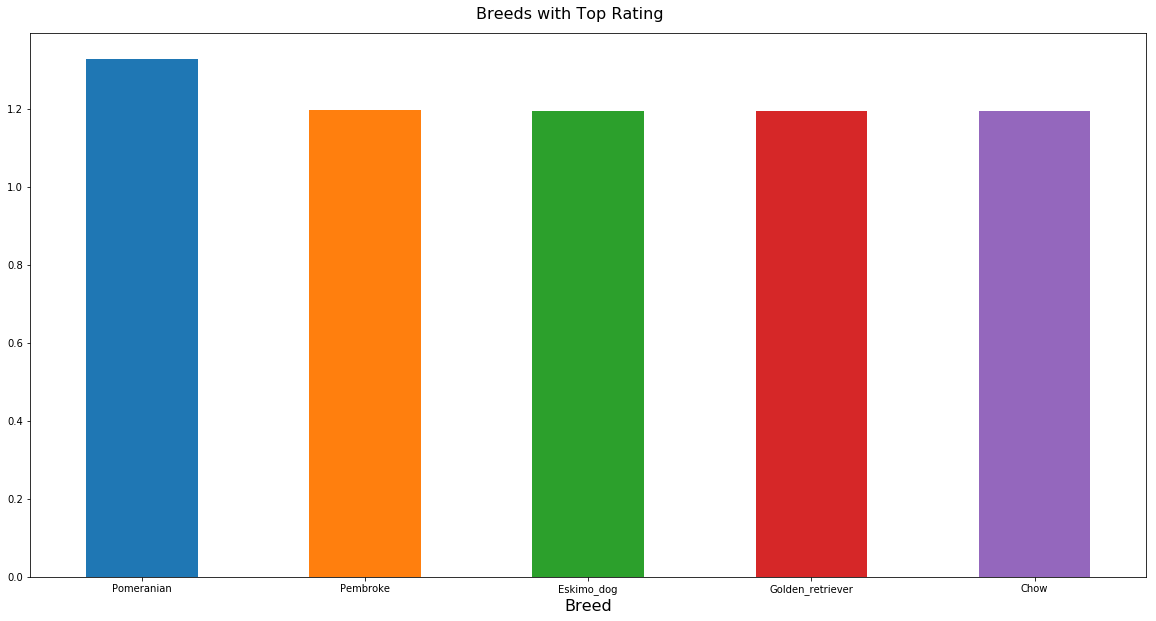

In [58]:
top_five_breed.plot(kind="bar", figsize=(20, 10), rot=0)
plt.figtext(.5,.9,'Breeds with Top Rating', fontsize=16, ha='center')
plt.xlabel('Breed', fontsize=16)

It looks like Pomeranian has the highest rating above all with an average rating of 1.33, with a large margin against the other four top contenders in the race, whereas the other four breeds in the top 5 category are quite close to each other, whose average ratings hover slight below 1.2. It isn't too far away from the dataset-wide average of 1.18, though. 

### Research Question 2: Which are the top breeds with most fans on the Twitter Community? How are they different from Research Question #1?

##### For the sake of simplicity, we'll simply define `favorite_count` as the indicator of number of fans. Again, we'll apply the same sample size threshold to this research question.

In [64]:
breed_most_fans = archive_clean_fiveup.groupby('p1').mean()['favorite_count'].nlargest(5).astype(int)

In [65]:
breed_most_fans

p1
French_bulldog      19414
Eskimo_dog          19052
Cardigan            15966
Samoyed             14574
Golden_retriever    14468
Name: favorite_count, dtype: int64

Text(0.5,0,'Breed')

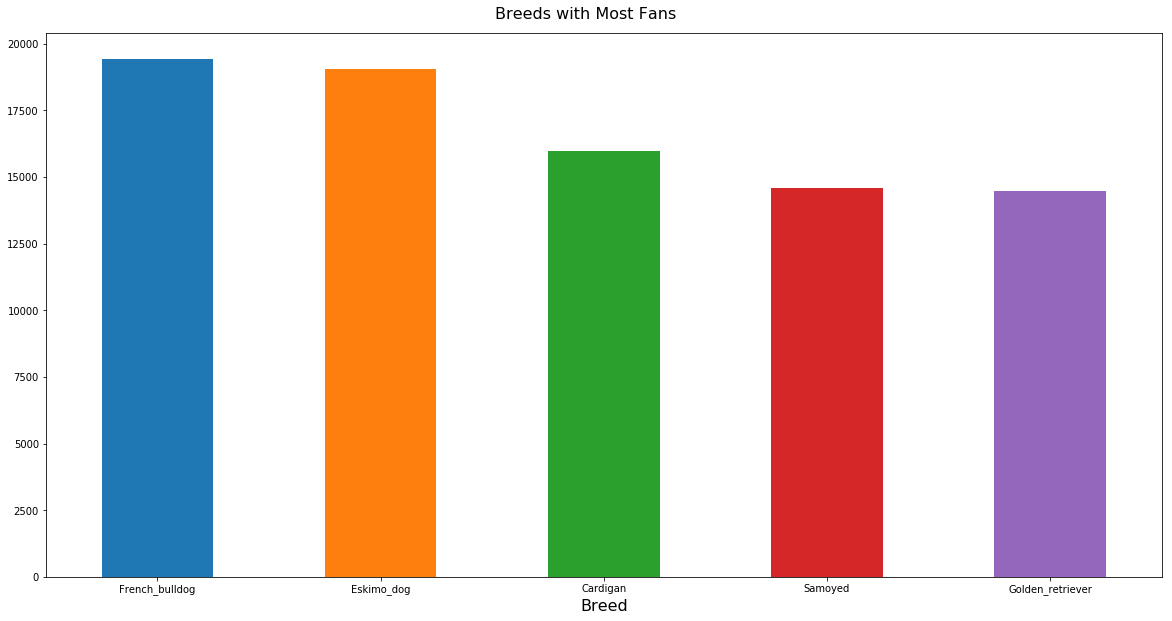

In [66]:
breed_most_fans.plot(kind="bar", figsize=(20,10), rot=0)
plt.figtext(.5,.9,'Breeds with Most Fans', fontsize=16, ha='center')
plt.xlabel('Breed', fontsize=16)

Interestingly, different from @WeRateDogs, the fans on Twitter seemed to prefer a different set of breeds. As we could see from the data summary as well as the bar chart, the top two breeds (French Bulldog and Eskimo Dog) have in average the highest count of favorites on Twitter (around 19,000). They have a large lead against the other three on this list (Cardigan, Samoyed, and Golden Retriever). Among the latter 3 Cardigan has a noticeable margin agianst Samoyed and Golden Retriever, which are almost head-to-head differentiated by 100+ counts. 

Now, from the list of top 5 breed with the highest rating, only Eskimo (#3) and Golden Retriever (#4) remain on the fan's favorite list, ranked #2 and #5 respectively. Eskimo trumps Goldern Retriever on both rankings and given the fact that it's almost tied to French Bulldong on the second ranking, we're fairly confident that Eskimo enjoys popularity with both the critic (in this case @WeRateDogs) and the general public on the Twitter community. Pomeranian is the critic's favorite, while French Bulldog is the most popular breed with the community.

### Research Question 3:  In which stage do the dogs enjoy the most popularity? 

##### We'll define "popularity" here in `retweet_count` and `favorite_count`. Let's conduct an analysis similar to the ones above.

In [70]:
popularity_by_stage = archive_clean_fiveup.groupby('stage').mean()[['retweet_count', 'favorite_count']].astype(int)

In [71]:
popularity_by_stage

,retweet_count,favorite_count
stage,,
Doggo,6496,20558
Floofer,5620,15448
Puffer,3357,11760
Puppo,3659,15891


Text(0,0.5,'Count')

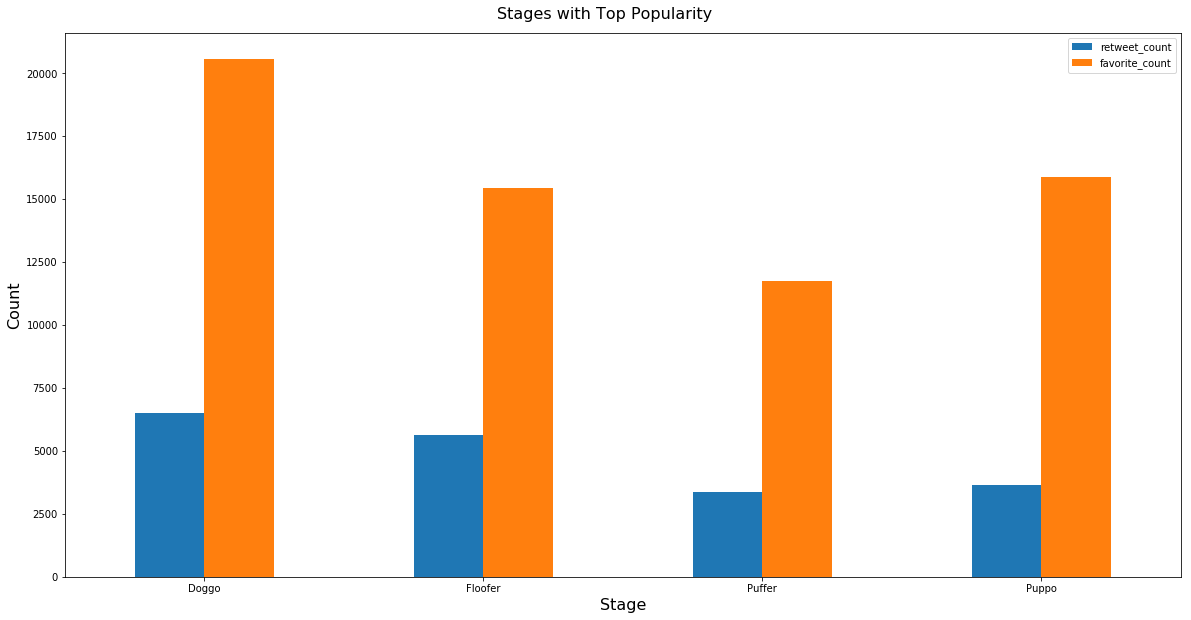

In [74]:
popularity_by_stage.plot(kind="bar", figsize=(20,10), rot=0)
plt.figtext(.5,.9,'Stages with Top Popularity', fontsize=16, ha='center')
plt.xlabel('Stage', fontsize=16)
plt.ylabel('Count', fontsize=16)

As we could see from the double bar chart, Doggo is the most popular stage leading in both `retweet_count` and `favorite_count`, followed by Floofer and Puppo with similar average statistics in both metrics. Comparatively, Puffer is not as popular as the other ones, especially in terms of `favorite_counts` which trail the other three by a significant margin.